In [ ]:
from tbparse import SummaryReader
df = SummaryReader("events.out.tfevents.1720042121.57e27c75779b").scalars


In [63]:
from pathlib import Path
from tbparse import SummaryReader
from tqdm import tqdm
import re
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
import pandas as pd

# POLICIES=list(Path("/Users/jszulc/Desktop/outputs/eureka/2024-07-03_20-53-07").rglob("policy*"))
METRIC = "consecutive_successes"
SAMPLES_PER_ITER=16

def parse_events(events):

    # e = tensorboard.data.experimental.ExperimentFromDev(POLICIES[0].as_posix)
    d = {}

    date_re = re.compile(r"(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})")
    def get_date(s):
        match = date_re.search(s)
        return datetime.strptime(match.group(1), "%Y-%m-%d_%H-%M-%S")

    for e in tqdm(events):
        policy_parent = e.parent.parent.parent.parent
        date = get_date(policy_parent.name)
        df = SummaryReader(e.as_posix()).scalars
        d[date] = df[df["tag"] == METRIC]

    _, values_per_sample = zip(*sorted(d.items()))
    for i, df in enumerate(values_per_sample):
        df["sample"] = i
        df["iter"] = df["sample"] // SAMPLES_PER_ITER

    return pd.concat(values_per_sample)

In [64]:
EVENTS_STATEFUL = list(Path("/Users/jszulc/Desktop/outputs/eureka/2024-07-03_20-53-07").rglob("**/events*"))
EVENTS_ORIGINAL = list(Path("/Users/jszulc/Desktop/outputs 2/eureka/2024-07-03_20-59-49").rglob("**/events*"))

In [65]:
d = parse_events(EVENTS_STATEFUL)


100%|██████████| 156/156 [00:02<00:00, 53.54it/s]


In [71]:
do = parse_events(EVENTS_ORIGINAL)

100%|██████████| 14/14 [00:07<00:00,  1.94it/s]


<Axes: >

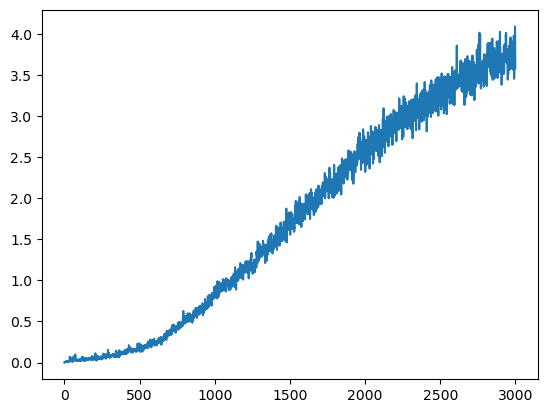

In [82]:
stateful = d.groupby(["iter", "step"]).agg({"value": "max"})["value"].reset_index()["value"]
original = do.groupby(["iter", "step"]).agg({"value": "max"})["value"].reset_index()["value"]
original = original[:len(stateful)]
# stateful = stateful[:len(original)]

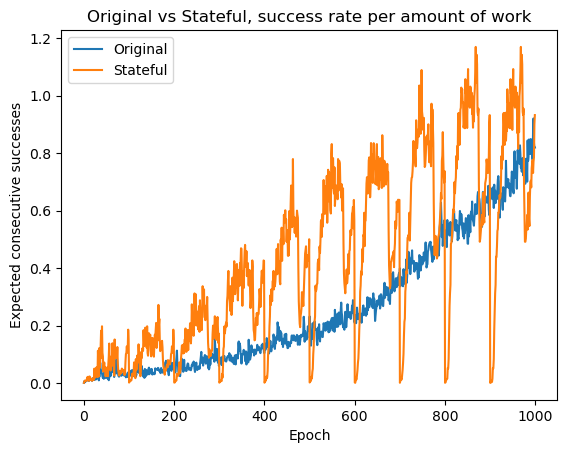

In [98]:
original.plot()
stateful.plot()
plt.xlabel("Epoch")
plt.ylabel("Expected consecutive successes")
plt.legend(["Original", "Stateful"])
plt.title("Original vs Stateful, success rate per amount of work")
import matplotlib.pyplot as plt

# Your code to generate the plot

plt.savefig('plot.tex', format='pgf')

<Axes: xlabel='iter,step'>

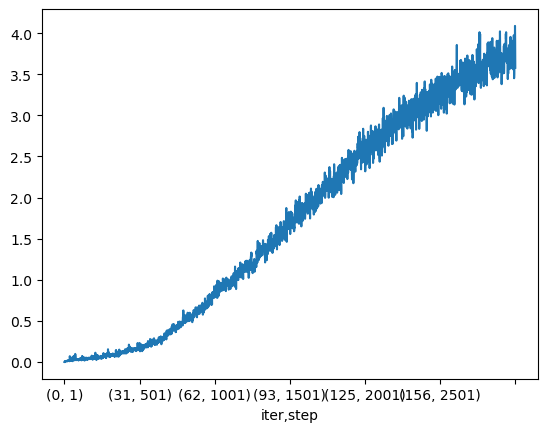

In [58]:
do.groupby(["iter", "step"]).agg({"value": "max"})["value"].plot()

In [33]:
l = list(list(d)[0])

In [35]:
list(l[1])

[]

In [25]:
np.load("summary.npz")["max_successes"]

array([0.09825404, 0.19749887, 0.2719349 , 0.33701089, 0.48076636,
       0.77956581, 0.83165854, 0.86254984, 1.08933353, 1.03708398,
       1.16976833])